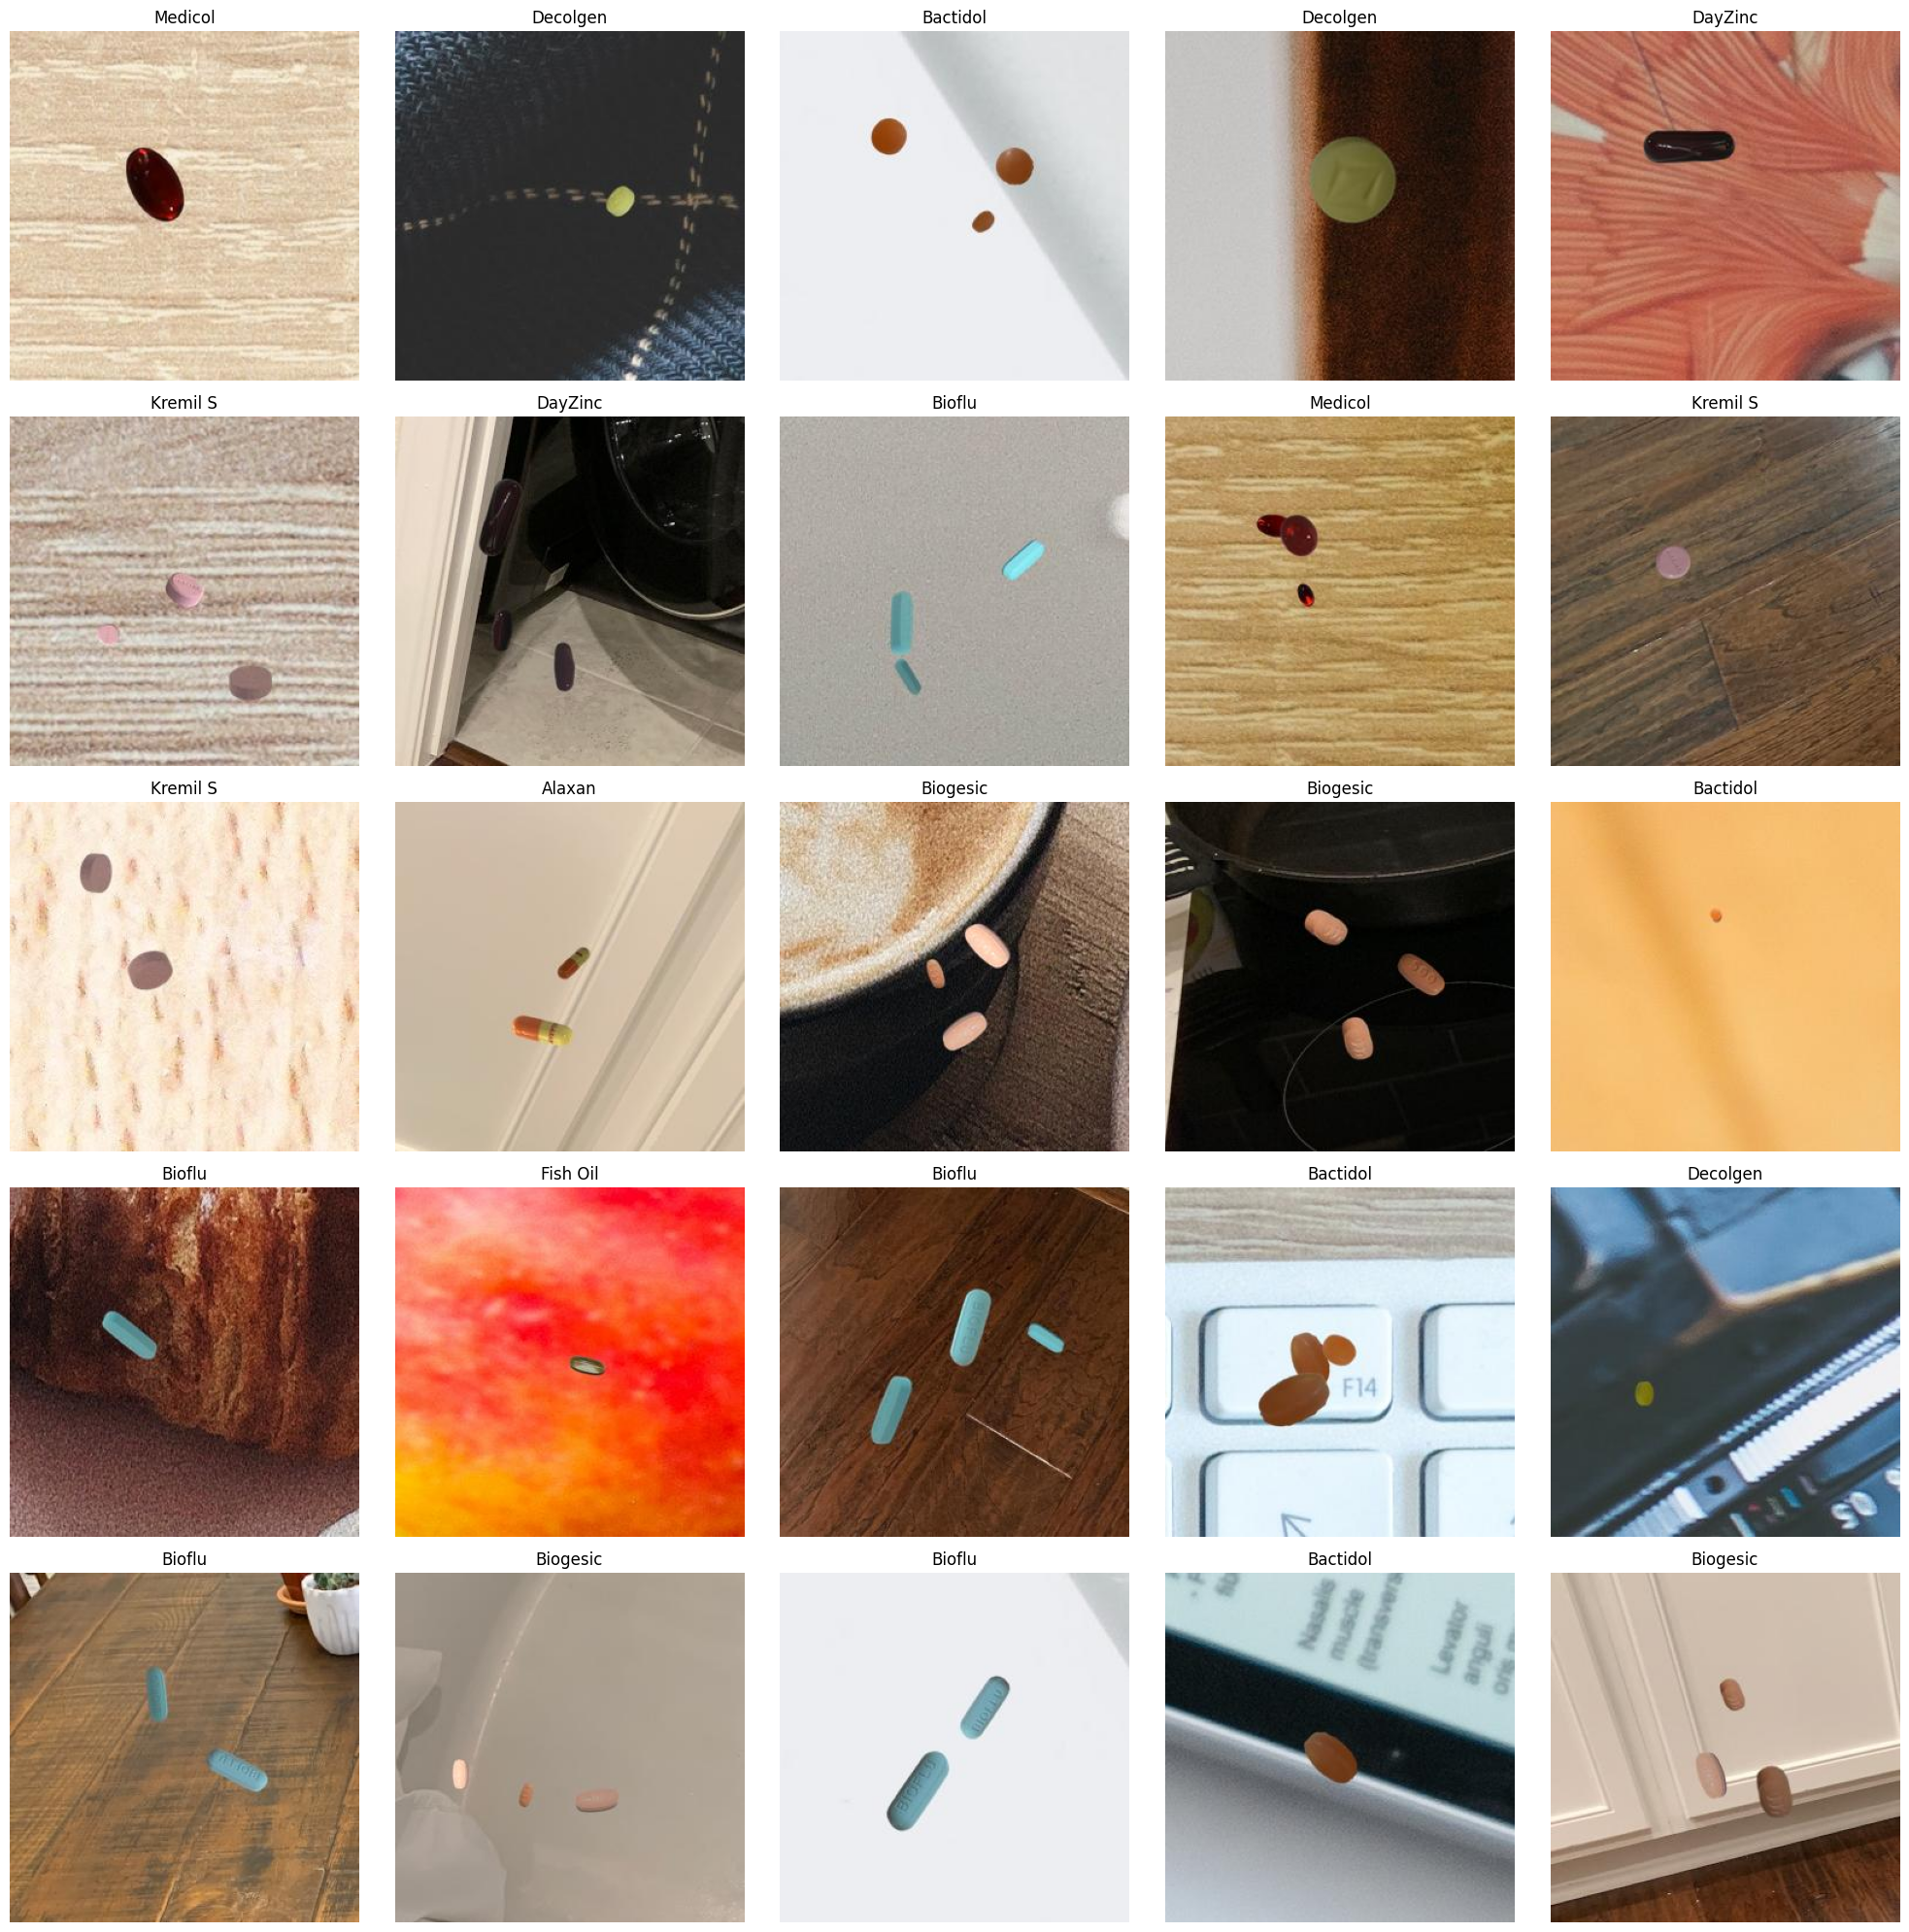

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling , Resizing  # preprocessing layers kullanılmadıgı için farklı sekilde import edilmistir

from tensorflow.keras.applications import MobileNetV2

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

dataset = "Drug Vision/Data Combined"
image_dir  = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

random_index = np.random.randint(0, len(image_df), 25)
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(ax.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
    ax.axis('off')
plt.tight_layout()

In [10]:
image_df.columns

Index(['Filepath', 'Label'], dtype='object')

In [13]:
train_df , test_df = train_test_split(image_df, test_size=0.2, shuffle=True)

train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath', # Görüntülerin dosya yolu
    y_col = 'Label', # Görüntü etiketleri
    target_size = (224, 224), # Tüm görüntüler 224x224 boyutuna getirilir
    color_mode = 'rgb', # Renkli görüntü (3 kanal: Kırmızı, Yeşil, Mavi)
    class_mode = 'categorical', # cok sinifli siniflandirma
    batch_size = 64, # Her iterasyonda 64 görüntü işlenir
    shuffle=True, # rastgele
    seed = 42, # Rastgelelik için sabit bir seed (aynı sonuçları almak için)
    subset = 'training' # Eğitim verisini al
)


validation_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64
)

resize_and_rescale = tf.keras.Sequential(
    [
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1.0/255)]
)

Found 6125 validated image filenames belonging to 10 classes.
Found 1531 validated image filenames belonging to 10 classes.
Found 1914 validated image filenames belonging to 10 classes.


In [15]:
pretrainded_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top = False, # mobile net sınıflandırma katmanıı dahil etme
    weights = 'imagenet', # hangi veri setiyle egitildigi
    pooling = 'avg'
)
pretrainded_model.trainable = False

# callbacks
ck_path = "pharmaceutical_drugs_and_vitamins_classification_model_checkpoint.weights.h5"
ck_call = ModelCheckpoint(ck_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True)

early_stop = EarlyStopping(monitor = "val_accuracy", patience = 3,restore_best_weights=True)

# build
inputs = pretrainded_model.input
x = pretrainded_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = Adam(0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

history = model.fit(train_images,steps_per_epoch = len(train_images),validation_data = validation_images,validation_steps = len(validation_images),epochs = 5,callbacks = [early_stop, ck_call])

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.2419 - loss: 2.1704 - val_accuracy: 0.6434 - val_loss: 1.2362
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6021 - loss: 1.2300 - val_accuracy: 0.7590 - val_loss: 0.8109
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7072 - loss: 0.9056 - val_accuracy: 0.7982 - val_loss: 0.6634
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7612 - loss: 0.7456 - val_accuracy: 0.8184 - val_loss: 0.5820
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7879 - loss: 0.6380 - val_accuracy: 0.8315 - val_loss: 0.5415


In [16]:
loss, accuracy = model.evaluate(test_images, verbose = 1)
print(f"loss : {loss}")
print(f"accuracy : {accuracy}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8003 - loss: 0.5961
loss : 0.5708909034729004
accuracy : 0.8098223805427551


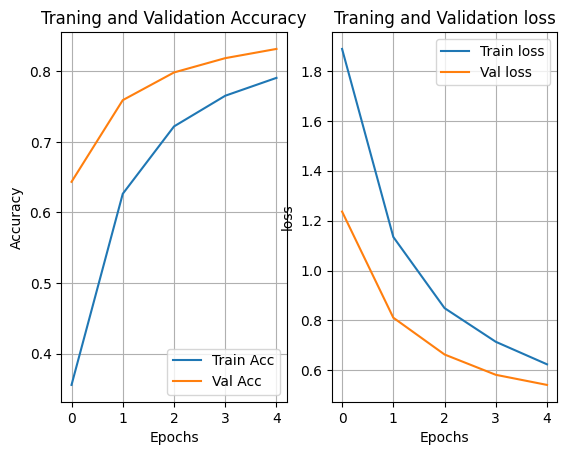

In [17]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Traning and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('True')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Traning and Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('True')

30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


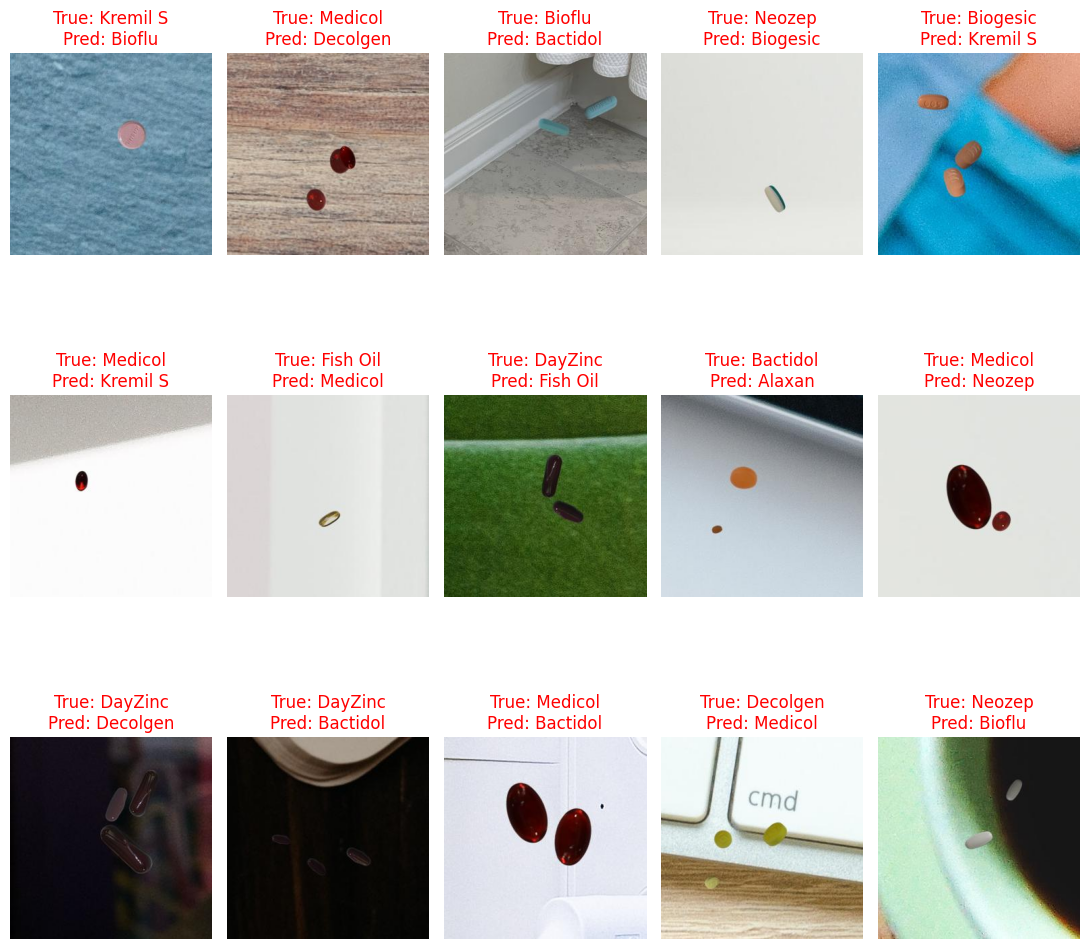

In [18]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred = [labels[k] for k in pred]

random_index = np.random.choice(test_df.index, 15, replace=False)
fig, ax = plt.subplots(3, 5, figsize=(11, 11))

for i, ax in enumerate(ax.flat):
    ax.imshow(plt.imread(test_df.Filepath.loc[random_index[i]]))
    true_label = test_df.Label.loc[random_index[i]]
    pred_label = pred[test_df.index.get_loc(random_index[i])]
    if true_label == pred_label:
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='green')
    else:
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(test_df.Label, pred))

              precision    recall  f1-score   support

      Alaxan       0.05      0.04      0.04       119
    Bactidol       0.11      0.11      0.11       197
      Bioflu       0.13      0.13      0.13       190
    Biogesic       0.12      0.12      0.12       220
     DayZinc       0.08      0.10      0.09       177
    Decolgen       0.09      0.09      0.09       215
    Fish Oil       0.09      0.09      0.09       205
    Kremil S       0.09      0.09      0.09       192
     Medicol       0.11      0.12      0.11       188
      Neozep       0.10      0.09      0.10       211

    accuracy                           0.10      1914
   macro avg       0.10      0.10      0.10      1914
weighted avg       0.10      0.10      0.10      1914

